### Import libraries

In [3]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model

### Datasets loading and preprocessing

In [4]:
(training_images, training_labels), (testing_images, testing_labels) = datasets.cifar10.load_data()
training_images, testing_images = training_images / 255, testing_images / 255

class_names = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# for i in range(16):
#     plt.subplot(4, 4, i + 1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.imshow(training_images[i], cmap = plt.cm.binary)
#     plt.xlabel(class_names[training_labels[i][0]])

# plt.show()

For optimization purposes, we limit the datasets' sizes.

In [5]:
training_images = training_images[:20000]
training_labels = training_labels[:20000]
testing_images = testing_images[:4000]
testing_labels = testing_labels[:4000]

### Model definition

In [6]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (32, 32, 3)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

C:\Users\Or Dinar\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Training

In [7]:
model.fit(training_images, training_labels, epochs=10, validation_data = (testing_images, testing_labels))

loss, accuracy = model.evaluate(testing_images, testing_labels)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

model.save_weights('Image_classifier.weights.h5')

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.2711 - loss: 1.9424 - val_accuracy: 0.4882 - val_loss: 1.3959
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.4908 - loss: 1.3909 - val_accuracy: 0.5422 - val_loss: 1.2627
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.5781 - loss: 1.1727 - val_accuracy: 0.5938 - val_loss: 1.1400
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.6356 - loss: 1.0340 - val_accuracy: 0.6342 - val_loss: 1.0269
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.6726 - loss: 0.9188 - val_accuracy: 0.6520 - val_loss: 0.9890
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.6972 - loss: 0.8546 - val_accuracy: 0.6435 - val_loss: 1.0006
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.7266 - loss: 0.7714 - val_accuracy: 0.6855 - val_loss: 0.9249
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.7573 - loss: 0.6947 - 

### Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Prediction: Dog


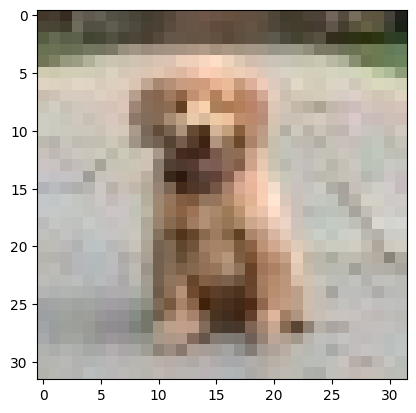

In [8]:
# img = cv2.imread('plane.png')
img = cv2.imread('dog.jpg')
# img = cv2.imread('volvo.jpeg')

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img, cmap = plt.cm.binary)

prediction = model.predict(np.array([img]) / 255)
index = np.argmax(prediction)

print(f'Prediction: {class_names[index]}')

### Visualization

In [ ]:
# Create a new model that will return outputs of all convolutional layers
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]

# Perform a forward pass to build the model
# This initializes the model by passing a sample image through it
model.predict(np.array([training_images[0]]))  # Pass one image from the dataset

# Now you can define the activation model
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Get activations for the resized image
activations = activation_model.predict(np.array([img]) / 255)

# Plot the activations for each convolutional layer
layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]

# Choose which layer's activations you want to visualize
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]  # Number of filters in the layer
    size = layer_activation.shape[1]  # Width/Height of the activation map
    
    # Tile all the feature maps in this layer into a grid
    n_cols = n_features // 8  # We will display 8 feature maps per row
    display_grid = np.zeros((size * n_cols, size * 8))
    
    for col in range(n_cols):
        for row in range(8):
            channel_image = layer_activation[0, :, :, col * 8 + row]
            # Post-process the feature to make it visually interpretable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std() + 1e-5
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size: (col + 1) * size,
                         row * size: (row + 1) * size] = channel_image
    
    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()